In [1]:
!pip install transformers jiwer pandas accelerate -U
!pip install datasets tokenizers seqeval -q
!pip install nltk
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 36.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 55.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 KB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 132.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 KB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 1.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 KB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 KB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 137.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 KB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 KB 15.2 MB/s eta 0:00:00
    

In [2]:
import os
import re
from collections import Counter

import pandas as pd
import jiwer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
!pip install ipywidgets
from tqdm import tqdm
from lime.lime_text import LimeTextExplainer
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# from .autonotebook import tqdm as notebook_tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package stopwords to /home/nkalra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
print(device)

cuda:0


In [28]:
import os
import pandas as pd

def ingest_idrisi_data(data_dir):
    sentences, labels = [], []

    # Traverse each folder inside Train or Test
    for root, dirs, files in os.walk(data_dir):
       
        for file_name in files:  # For each file inside the current directory
           
            if file_name.endswith('.txt'):  # Process any .txt file
                file_path = os.path.join(root, file_name)
               
                
                with open(file_path, 'r') as f:
                    current_sentence, current_labels = [], []
                    for line in f:
                        word_label = line.strip().split()
                        if len(word_label) == 2:
                            word, label = word_label
                            current_sentence.append(word)
                            current_labels.append(label)
                        elif len(current_sentence) > 0:
                            # Sentence boundary: Append sentence and its labels
                            sentences.append(' '.join(current_sentence))
                            labels.append(','.join(current_labels))
                           
                            current_sentence, current_labels = [], []
                    if len(current_sentence) > 0:
                        # Add the last sentence (if any) when file ends
                        sentences.append(' '.join(current_sentence))
                        labels.append(','.join(current_labels))
                   

    return pd.DataFrame({'sentence': sentences, 'word_labels': labels})


In [4]:
train_df= ingest_idrisi_data('Train')
test_df= ingest_idrisi_data('Test')

test_california= ingest_idrisi_data('Test/california_wildfires_2018_loc_notok')
test_idai= ingest_idrisi_data('Test/cyclone_idai_2019_loc_notok')
test_pakistan= ingest_idrisi_data('Test/pakistan_earthquake_2019_loc_notok')
test_dorian= ingest_idrisi_data('Test/hurricane_dorian_2019_loc_notok')
test_midwestern= ingest_idrisi_data('Test/midwestern_us_floods_2019_loc_notok')

In [5]:
t1= ingest_idrisi_data('Train/srilanka_floods_2017_loc_notok')
t2= ingest_idrisi_data('Train/puebla_mexico_earthquake_2017_loc_notok')
t3= ingest_idrisi_data('Train/maryland_floods_2018_loc_notok')
t4= ingest_idrisi_data('Train/kerala_floods_2018_loc_notok')
t5= ingest_idrisi_data('Train/kaikoura_earthquake_2016_loc_notok')
t6= ingest_idrisi_data('Train/ecuador_earthquake_2016_loc_notok')
t7= ingest_idrisi_data('Train/italy_earthquake_aug_2016_loc_notok')

print(len(t1), len(t2), len(t3), len(t4), len(t5), len(t6), len(t7))

len(test_df)


368 1040 344 1040 992 928 472


7651

In [6]:
def unify_loc_labels(df):
    # Modify the 'word_labels' column to replace B-LOC, I-LOC, L-LOC, and U-LOC with LOC
    df['word_labels'] = df['word_labels'].apply(lambda x: re.sub(r'\b[BILU]-LOC\b', 'LOC', x))
    return df

In [7]:
train_df= unify_loc_labels(train_df)
test_df= unify_loc_labels(test_df)

test_california= unify_loc_labels(test_california)
test_midwestern= unify_loc_labels(test_midwestern)
test_pakistan= unify_loc_labels(test_pakistan)
test_dorian= unify_loc_labels(test_dorian)
test_idai= unify_loc_labels(test_idai)
test_newdata=unify_loc_labels(test_newdata)

NameError: name 'test_newdata' is not defined

# PRE-PROCESSING ????

In [9]:
# Check if any sentences have a mismatch in word and label count
train_df['sentence_len'] = train_df['sentence'].apply(lambda x: len(x.split()))
train_df['label_len'] = train_df['word_labels'].apply(lambda x: len(x.split(',')))

# Identify mismatches
mismatched = train_df[train_df['sentence_len'] != train_df['label_len']]
if not mismatched.empty:
    print("Mismatched entries found!")
    print(mismatched)




Before fine-tuning, it’s essential to map the location mention labels from the BILOU format to a format that BERT can understand. This involves converting categorical labels (e.g., B-CITY,B-CNTY, B-CONT) into integer IDs, which the model will use during training. This mapping is critical because BERT outputs logits for each token, which are then converted back to these labels.

In [ ]:
# Extract unique tags from word labels
tags = set(",".join(train_df.word_labels).split(','))

# Create label to ID and ID to label mappings
label2id = {k: v for v, k in enumerate(tags)}
id2label = {v: k for v, k in enumerate(tags)}

In [11]:
label2id

{'O': 0, 'LOC': 1}

# BERT works on wordpiece tokenization rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!


In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]  
        word_labels = self.data.word_labels[index]  
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)
        
        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]
        
        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]
        
        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 1
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
training_set = dataset(train_df, tokenizer, MAX_LEN)
testing_set = dataset(test_df, tokenizer, MAX_LEN)

testset_california=  dataset(test_california, tokenizer, MAX_LEN)

testset_idai= dataset(test_idai, tokenizer, MAX_LEN)
testset_pakistan= dataset(test_pakistan, tokenizer, MAX_LEN)
testset_dorian= dataset(test_dorian, tokenizer, MAX_LEN)
testset_midwestern= dataset(test_midwestern, tokenizer, MAX_LEN)


testset_newdata=  dataset(test_newdata, tokenizer, MAX_LEN)

In [16]:

# Convert the 'ids' back to tokens
tokens = tokenizer.convert_ids_to_tokens(training_set[0]['ids'].tolist())

# Convert label ids to actual labels using id2label
labels = [id2label[label.item()] for label in training_set[0]['targets']]

print("Tokens:", tokens)
print("Labels:", labels)


Tokens: ['[CLS]', 'developing', ':', 'flash', 'flooding', ',', 'water', 'rescues', 'reported', 'in', 'maryland', 'as', 'heavy', 'rain', 'so', '##aks', 'much', 'of', 'the', 'state', '.', 'video', 'shows', 'water', 'rushing', 'down', 'main', 'street', 'in', 'el', '##lic', '##ott', 'city', ',', 'just', 'outside', 'baltimore', '.', 'its', 'the', 'same', 'street', 'devastated', 'by', 'flash', 'flooding', 'in', 'july', '2016', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

In [17]:
# print the first 10 tokens and corresponding labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["ids"][:40]), training_set[0]["targets"][:40]):
  print('{0:10}  {1}'.format(token, id2label[label.item()]))



[CLS]       O
developing  O
:           O
flash       O
flooding    O
,           O
water       O
rescues     O
reported    O
in          O
maryland    LOC
as          O
heavy       O
rain        O
so          O
##aks       O
much        O
of          O
the         O
state       O
.           O
video       O
shows       O
water       O
rushing     O
down        O
main        O
street      O
in          O
el          LOC
##lic       LOC
##ott       LOC
city        LOC
,           O
just        O
outside     O
baltimore   LOC
.           O
its         O
the         O


In [ ]:
# pytorch data loaders
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

testing_california= DataLoader(testset_california, **test_params)
testing_idai= DataLoader(testset_idai, **test_params)
testing_pakistan= DataLoader(testset_pakistan, **test_params)
testing_dorian= DataLoader(testset_dorian, **test_params)
testing_midwestern= DataLoader(testset_midwestern, **test_params)
# testing_newdata= DataLoader(testset_newdata, **test_params)


In [19]:
# model = BertForTokenClassification.from_pretrained('bert-base-uncased', 
#                                                    num_labels=len(id2label),
#                                                    id2label=id2label,
#                                                    label2id=label2id)
# model.to(device)

In [ ]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_preds.extend(predictions)
        tr_labels.extend(targets)
        
        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# for epoch in range(EPOCHS):
#     print(f"Training epoch: {epoch + 1}")
#     train(epoch)

In [174]:
# model.save_pretrained("ner_model1")
# tokenizer.save_pretrained("tokenizer1")



In [29]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Load the saved model
model = AutoModelForTokenClassification.from_pretrained("ner_model1")
model.to(device)

# Load the saved tokenizer
tokenizer = AutoTokenizer.from_pretrained("tokenizer1")


In [30]:
from transformers import pipeline
# THIS IS HAPPENING BECAUSE PIPELINE IS ONLY FOR IOB FORMATS RIGHT NOW!!!!!

nlp = pipeline("token-classification",model=model.to(device),tokenizer=tokenizer, aggregation_strategy="simple")
example = ("Floods detected in the Raipur district")
nlp(example)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity_group': 'LOC',
  'score': np.float32(0.86453176),
  'word': 'raipur',
  'start': 23,
  'end': 29}]

In [31]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

def valid(model, testing_loader, tokenizer, id2label, original_texts):
    # Put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps = 0
    all_results = []  # To store all results in a flat list
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            ids = batch['ids'].to(model.device)
            mask = batch['mask'].to(model.device)
            targets = batch['targets'].to(model.device)
            tweet_text = original_texts[idx]  # Access the original tweet text
            
            # Forward pass through the model
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits
            
            eval_loss += loss.item()
            nb_eval_steps += 1
            
            # Compute predictions and mask out special tokens
            flattened_targets = targets.view(-1)
            active_logits = eval_logits.view(-1, model.num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)
            
            active_accuracy = mask.view(-1) == 1
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            # Convert token IDs back to tokens
            tokens = tokenizer.convert_ids_to_tokens(ids[0])  # For the first batch
            
            # Store results for this tweet
            tweet_results = []
            for i, (token, label, pred) in enumerate(zip(tokens, targets, predictions)):
                label_str = id2label[label.item()]  # Get label string from label id
                pred_str = id2label[pred.item()]  # Get prediction string from predicted id
                
                # Get probabilities for each token's predicted label (apply softmax)
                token_probs = F.softmax(active_logits[i], dim=-1).cpu().numpy()  # Probabilities for the current token
                token_pred_prob = token_probs[np.argmax(token_probs)]  # Probability for the predicted label
                
                # Append token-level results, including the tweet text
                tweet_results.append({
                    'tweet_text': tweet_text,  # Include the original tweet text
                    'token': token,
                    'label': label_str,
                    'prediction': pred_str,
                    'proba': token_pred_prob  # Include the predicted probability for this token
                })
            
            # Add results for this tweet
            all_results.append(tweet_results)
            
            # Update accuracy
            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy
    
    # Finalize average loss and accuracy
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return all_results  # This will return a list of dictionaries for each tweet



## DOING THE SAME SETS FOR ALL DATASETS

In [32]:
#STEP 1: VALIDATION
# all_results_california= valid(model, testing_california, tokenizer,id2label, test_california['sentence'])
# all_results_idai= valid(model, testing_idai, tokenizer,id2label, test_idai['sentence'])
# all_results_pakistan= valid(model, testing_pakistan, tokenizer,id2label, test_pakistan['sentence'])
# all_results_dorian= valid(model, testing_dorian, tokenizer,id2label, test_dorian['sentence'])
# all_results_midwestern= valid(model, testing_midwestern, tokenizer,id2label, test_midwestern['sentence'])




In [4]:
import pickle
import numpy as np

def save_all_results(all_results, filename=None):
    """
    Saves the all_results list to a pickle file with a custom filename.
    
    Parameters:
        all_results (list): The list containing token, label, prediction, and proba for each token in each tweet.
        filename (str, optional): The filename to save the pickle file. Default is None, which saves to 'all_results.pkl'.
    """
    if filename is None:
        filename = "all_results.pkl"
    
    with open(filename, 'wb') as f:
        pickle.dump(all_results, f)
    print(f"All results saved to {filename}")

def load_all_results(filename=None):
    """
    Loads the all_results list from a pickle file with a custom filename.
    
    Parameters:
        filename (str, optional): The filename to load the pickle file from. Default is None, which loads from 'all_results.pkl'.
    
    Returns:
        list: A list containing token, label, prediction, and proba for each token in each tweet.
    """
    if filename is None:
        filename = "all_results.pkl"
    
    with open(filename, 'rb') as f:
        all_results = pickle.load(f)
    print(f"All results loaded from {filename}")
    return all_results


In [5]:
#Step 2: Saving these validation results
# save_all_results(all_results_california, filename="all_results_california.pkl")
# save_all_results(all_results_idai, filename="all_results_idai.pkl")
# save_all_results(all_results_pakistan, filename="all_results_pakistan.pkl")
# save_all_results(all_results_dorian, filename="all_results_dorian.pkl")
# save_all_results(all_results_midwestern, filename="all_results_midwestern.pkl")

# save_all_results(all_results, filename="all_results.pkl")
all_results=load_all_results(filename="all_results.pkl")

all_results_california=load_all_results(filename="all_results_california.pkl")
all_results_idai = load_all_results(filename="all_results_idai.pkl")
all_results_pakistan = load_all_results(filename="all_results_pakistan.pkl")
all_results_dorian = load_all_results(filename="all_results_dorian.pkl")
all_results_midwestern = load_all_results(filename="all_results_midwestern.pkl")

All results loaded from all_results.pkl
All results loaded from all_results_california.pkl
All results loaded from all_results_idai.pkl
All results loaded from all_results_pakistan.pkl
All results loaded from all_results_dorian.pkl
All results loaded from all_results_midwestern.pkl


In [6]:
#Step 4: F1 Score calculation

from sklearn.metrics import f1_score, classification_report

def calculate_f1_and_report(results):
    all_true_labels = []
    all_preds = []

    for tweet_result in results:
        for item in tweet_result:
            token = item['token']
            true_label = item['label']
            pred_label = item['prediction']

            # Exclude special tokens: [CLS], [SEP], and [PAD]
            if token not in ['[CLS]', '[SEP]', '[PAD]']:  # Exclude special tokens
                all_true_labels.append(true_label)
                all_preds.append(pred_label)
    
    # Calculate F1 score for the labels
    f1 = f1_score(all_true_labels, all_preds, average='macro')  # Use 'weighted' for multi-class tasks

    # Print the classification report
    report = classification_report(all_true_labels, all_preds)
    print("Classification Report:")
    print(report)

    return f1
    
results=[all_results_california, all_results_idai, all_results_pakistan, all_results_dorian, all_results_midwestern]
for i in range(len(results)):
    print(calculate_f1_and_report(results[i]))

Classification Report:
              precision    recall  f1-score   support

         LOC       0.83      0.85      0.84      1510
           O       0.99      0.99      0.99     38639

    accuracy                           0.99     40149
   macro avg       0.91      0.92      0.92     40149
weighted avg       0.99      0.99      0.99     40149

0.9167758374182776
Classification Report:
              precision    recall  f1-score   support

         LOC       0.84      0.87      0.85      2210
           O       0.99      0.99      0.99     45463

    accuracy                           0.99     47673
   macro avg       0.92      0.93      0.92     47673
weighted avg       0.99      0.99      0.99     47673

0.9227006274704715
Classification Report:
              precision    recall  f1-score   support

         LOC       0.88      0.76      0.82      2123
           O       0.97      0.99      0.98     19658

    accuracy                           0.97     21781
   macro avg       0.

In [6]:
from sklearn.metrics import f1_score, classification_report
def count_negative_tweets(all_results):
    negative_tweets_count = 0
    negative_tweet_indices = []
    negative_tweets = []
    
    # Iterate over all tweets
    for idx, tweet_results in enumerate(all_results):
        tweet_is_negative = True  # Assume it's a negative tweet unless proven otherwise
        
        # Check each token's prediction for the tweet
        for entry in tweet_results:
            if entry['prediction'] == 'LOC':
                tweet_is_negative = False  # It's not a negative tweet if 'LOC' is predicted
                break
        
        # If the tweet is negative (no 'LOC' predicted), count it and store the tweet and its index
        if tweet_is_negative:
            negative_tweets_count += 1
            negative_tweet_indices.append(idx)
            negative_tweets.append(tweet_results)

    return negative_tweets_count, negative_tweet_indices, negative_tweets


def count_false_negatives_in_negative_tweets(tweets):

    false_negatives_count = 0
    false_negative_tweets = []
  

    for tweet_results in tweets:
        tweet_has_false_negative = False  # Track if this tweet has any false negatives
        
        for entry in tweet_results:
            if entry['label'] == 'LOC' and entry['prediction'] != 'LOC':
                false_negatives_count += 1
                tweet_has_false_negative = True
        
        # If the tweet has any false negatives, add it to the list
        if tweet_has_false_negative:
            false_negative_tweets.append(tweet_results)
                  

    return false_negatives_count, false_negative_tweets


def filter_negative_tweets_by_min_prob_and_percentile(negative_tweets, percentile=30):
    min_probs_list = []
    
    # Step 1: Calculate the minimum probability for each negative tweet
    for tweet_results in negative_tweets:
        tweet_min_prob = float('inf')  # Initialize with a very high value to get the minimum
        
        # Iterate through tokens in the tweet to find the minimum probability
        for token_result in tweet_results:
            token_prob = token_result.get('proba', None)
            if token_prob is not None:
                tweet_min_prob = min(tweet_min_prob, token_prob)
        
        min_probs_list.append(tweet_min_prob)
    
    # Step 2: Calculate the 30th percentile value
    percentile_value = np.percentile(min_probs_list, percentile)
    # print(f"30th Percentile of Minimum Probabilities: {percentile_value}")
    
    # Step 3: Get the indices of tweets below or equal to the 30th percentile
    low_confidence_indices = [i for i, prob in enumerate(min_probs_list) if prob <= percentile_value]
    
    # Step 4: Filter the tweets based on the low confidence indices
    filtered_negative_tweets = [negative_tweets[i] for i in low_confidence_indices]

    return filtered_negative_tweets, min_probs_list, percentile_value, low_confidence_indices



def false_negative_percentage_in_low_confidence(false_negatives_count,false_negatives_count_lc):
    if false_negatives_count > 0:
        false_negative_percentage_in_low_confidence = ((false_negatives_count_lc / false_negatives_count) * 100)
    else:
        false_negative_percentage_in_low_confidence = 0  # Avoid division by zero
    
    return false_negative_percentage_in_low_confidence


def calculate_f1(results):
    all_true_labels = []
    all_preds = []

    for tweet_result in results:
        for item in tweet_result:
            token = item['token']
            true_label = item['label']
            pred_label = item['prediction']

            # Exclude special tokens: [CLS], [SEP], and [PAD]
            if token not in ['[CLS]', '[SEP]', '[PAD]']:  # Exclude special tokens
                all_true_labels.append(true_label)
                all_preds.append(pred_label)
    
    # Calculate F1 score for the labels
    f1 = f1_score(all_true_labels, all_preds, average='macro')  # Use 'weighted' for multi-class tasks

    return f1

In [30]:
# A function that combines them all together

def give_results(all_results):
    f1= calculate_f1(all_results)
    negative_tweets_count, negative_tweet_indices, negative_tweets= count_negative_tweets(all_results)
    false_negatives_count, false_negative_tweets= count_false_negatives_in_negative_tweets(negative_tweets)
    filtered_negative_tweets, min_probs_list, percentile_value, low_confidence_indices= filter_negative_tweets_by_min_prob_and_percentile(negative_tweets, percentile=30)
    false_negatives_count_lc, false_negative_tweets_lc = count_false_negatives_in_negative_tweets(filtered_negative_tweets)
    percentage= false_negative_percentage_in_low_confidence(len(false_negative_tweets),len(false_negative_tweets_lc))


    print(f"Total no. of Tweets:{len(all_results)} ")
    print(f"Macro F1 Score:  {f1:.2f}")
    print(f"Total no. of Negative Tweets: {negative_tweets_count}")
    print(f"No of tweets with false negatives in Negative Tweets: {len(false_negative_tweets)}")
    print(f"30th Percentile of Min probs: {percentile_value}")
    print(f"Total filtered tweets (below 30th percentile): {len(filtered_negative_tweets)}")
    print(f"No. of FN tweets below 30th percentile: {len(false_negative_tweets_lc)}")
    print(f"Percentage of FN tweets in low confidence: {percentage:.2f} %")
    # return false_negative_tweets_lc
    # return filtered_negative_tweets
    #return negative_tweets_count, negative_tweet_indices, negative_tweets
 


def get_n_lc_tweets(results):
    ls=[]
    for tweet in results:
        ls.append(tweet[0]['tweet_text'])
    return ls
    
    

In [119]:
# california=give_results(all_results_california)
# california_n_lc= get_n_lc_tweets(california)



Total no. of Tweets:1170 
Macro F1 Score:  0.92
Total no. of Negative Tweets: 206
No of tweets with false negatives in Negative Tweets: 10
30th Percentile of Min probs: 0.96612948179245
Total filtered tweets (below 30th percentile): 62
No. of FN tweets below 30th percentile: 8
Percentage of FN tweets in low confidence: 80.00 %


In [40]:
# all=give_results(all_results)


Total no. of Tweets:3820 
Macro F1 Score:  0.92
Total no. of Negative Tweets: 711
No of tweets with false negatives in Negative Tweets: 64
30th Percentile of Min probs: 0.9558238387107849
Total filtered tweets (below 30th percentile): 214
No. of FN tweets below 30th percentile: 44
Percentage of FN tweets in low confidence: 68.75 %


In [42]:
# idai=give_results(all_results_idai)
# idai_n_lc= get_n_lc_tweets(idai)

Total no. of Tweets:1040 
Macro F1 Score:  0.92
Total no. of Negative Tweets: 290
No of tweets with false negatives in Negative Tweets: 26
30th Percentile of Min probs: 0.9338523149490356
Total filtered tweets (below 30th percentile): 87
No. of FN tweets below 30th percentile: 13
Percentage of FN tweets in low confidence: 50.00 %


In [43]:
# pakistan=give_results(all_results_pakistan)
# pakistan_n_lc= get_n_lc_tweets(pakistan)

Total no. of Tweets:616 
Macro F1 Score:  0.90
Total no. of Negative Tweets: 116
No of tweets with false negatives in Negative Tweets: 18
30th Percentile of Min probs: 0.9871402978897095
Total filtered tweets (below 30th percentile): 35
No. of FN tweets below 30th percentile: 17
Percentage of FN tweets in low confidence: 94.44 %


In [44]:
# dorian=give_results(all_results_dorian)
# dorian_n_lc= get_n_lc_tweets(dorian)

Total no. of Tweets:130 
Macro F1 Score:  0.91
Total no. of Negative Tweets: 37
No of tweets with false negatives in Negative Tweets: 4
30th Percentile of Min probs: 0.9738486409187317
Total filtered tweets (below 30th percentile): 11
No. of FN tweets below 30th percentile: 3
Percentage of FN tweets in low confidence: 75.00 %


In [45]:
# midwestern=give_results(all_results_midwestern)
# midwestern_n_lc= get_n_lc_tweets(midwestern)

Total no. of Tweets:864 
Macro F1 Score:  0.93
Total no. of Negative Tweets: 62
No of tweets with false negatives in Negative Tweets: 6
30th Percentile of Min probs: 0.9081556797027588
Total filtered tweets (below 30th percentile): 19
No. of FN tweets below 30th percentile: 6
Percentage of FN tweets in low confidence: 100.00 %


In [146]:
# Saving all these values
# save_all_results(california_fn_lc, filename="california.pkl")
# save_all_results(idai_fn_lc, filename="idai.pkl")
# save_all_results(pakistan_fn_lc, filename="pakistan.pkl")
# save_all_results(dorian_fn_lc, filename="dorian.pkl")
# save_all_results(midwestern_fn_lc, filename="midwestern.pkl")
# newnew=give_results(all_results_new)
# newnew_fn_lc= get_n_lc_tweets(newnew)
# save_all_results(newnew_fn_lc, filename="newnew.pkl")


# Saving all these values
# save_all_results(california_n_lc, filename="california_neg.pkl")
# save_all_results(idai_n_lc, filename="idai_neg.pkl")
# save_all_results(pakistan_n_lc, filename="pakistan_neg.pkl")
# save_all_results(dorian_n_lc, filename="dorian_neg.pkl")
# save_all_results(midwestern_n_lc, filename="midwestern_neg.pkl")


# Loading results
california=load_all_results(filename="california_neg.pkl")
idai = load_all_results(filename="idai_neg.pkl")
pakistan = load_all_results(filename="pakistan_neg.pkl")
dorian = load_all_results(filename="dorian_neg.pkl")
midwestern = load_all_results(filename="midwestern_neg.pkl")

Total no. of Tweets:1277 
Macro F1 Score:  0.81
Total no. of Negative Tweets: 17
No of tweets with false negatives in Negative Tweets: 5
30th Percentile of Min probs: 0.7423974275588989
Total filtered tweets (below 30th percentile): 5
No. of FN tweets below 30th percentile: 4
Percentage of FN tweets in low confidence: 80.00 %
All results saved to newnew.pkl
All results loaded from california_neg.pkl
All results loaded from idai_neg.pkl
All results loaded from pakistan_neg.pkl
All results loaded from dorian_neg.pkl
All results loaded from midwestern_neg.pkl


In [122]:
len(california)

62

In [ ]:
# Create a list with all the values

all_n_lc= california+ dorian + pakistan + midwestern + idai
# save_all_results(all_n_lc, filename="all_negatives.pkl")
all_n_lc = load_all_results(filename="all_negatives.pkl")

In [37]:
len(all_n_lc)

214

# LIME EXPLANATIONS

In [127]:
import numpy as np
import torch.nn.functional as F

class BERTForNERWrapper:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def predict_proba(self, texts):
        """
        This function takes in a list of text sequences (perturbed by LIME) 
        and returns the probability distribution of predicted classes for the entire sequence.
        We aggregate the token-level probabilities by taking their average.
        """
        all_probs = []
        max_len = MAX_LEN  # Ensure a consistent length

        for text in texts:
            # Tokenize the input text
            inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_len).to(self.device)

            # Forward pass through the model to get logits
            outputs = self.model(**inputs)
            logits = outputs.logits.detach().cpu()  # Detach the logits from the computation graph

            # Apply softmax to the logits to convert them into probabilities
            probs = F.softmax(logits, dim=-1).numpy()

            # Get token probabilities for the first batch element
            token_probs = probs[0]  # Shape: (seq_len, num_labels)

            # Aggregate the probabilities across tokens by averaging them
            avg_probs = np.mean(token_probs, axis=0)  # Shape: (num_labels,)

            # Store the averaged probabilities
            all_probs.append(avg_probs)
        
        return np.array(all_probs)

In [94]:
# !pip install lime
from lime.lime_text import LimeTextExplainer

# Create a LimeTextExplainer for your task
explainer = LimeTextExplainer(class_names=[id2label[i] for i in range(len(id2label))])

# Wrap BERT model for LIME
wrapped_model = BERTForNERWrapper(model, tokenizer, device)

# Select a sentence to explain
sample_sentence = "Flood relief center established by UNMC / Nebraska Medicine , UNO"

# Get LIME explanations
exp = explainer.explain_instance(sample_sentence, wrapped_model.predict_proba, num_features=6)

# Visualize the explanation
exp.show_in_notebook(text=True)


In [92]:
exp.as_list()

[(np.str_('Nebraska'), -0.08093859923837687),
 (np.str_('Medicine'), 0.04587418512251395),
 (np.str_('by'), 0.04044264819541375),
 (np.str_('UNO'), -0.02574907614548185),
 (np.str_('relief'), 0.01801084471600365),
 (np.str_('established'), 0.017248680382758525),
 (np.str_('center'), -0.012621641385133437),
 (np.str_('Flood'), 0.006757747888670603),
 (np.str_('UNMC'), 0.002605566656976204)]

In [84]:
# save_all_results(least_contributing_words_per_tweet, filename="lime_words.pkl")

All results saved to lime_words.pkl


In [3]:
lime_words= load_all_results(filename="lime_words.pkl")

All results loaded from lime_words.pkl


In [6]:
lime_words[1:3]

[{'tweet': 'This is an absolutely heartless response . There are n’t even politics involved . Just good American families losing their homes as you tweet , evacuating into shelters .',
  'least_contributing_words': [np.str_('American'), np.str_('n')]},
 {'tweet': 'The newest reported death now raises the death toll from the latest batch of CA wildfires to 31 and makes these the deadliest wildfires in state history :',
  'least_contributing_words': [np.str_('CA'), np.str_('wildfires')]}]

In [8]:
df

,tweet,least_contributing_words
0,This guy is awesome ! Buy a shirt til Monday ....,"[CA, fires]"
1,This is an absolutely heartless response . The...,"[American, n]"
2,The newest reported death now raises the death...,"[CA, wildfires]"
3,Please help if you can . Even if a retweet is ...,"[Norcal, native]"
4,People displaced by Camp Fire make temporary h...,"[Walmart, in]"
5,Camp - Fire CA 71dead1600 missing Hundreds are...,"[Walmart, of]"
6,If you are stocking up on beer for your # Than...,"[Nevada, via]"
7,This guy is awesome ! Buy a shirt til Monday ....,"[CA, fires]"
8,Dorian is still a category 5 hurricane . The s...,"[Chatham, cone]"
9,# HurricaneDorian is devastating islands south...,"[south, us]"


In [184]:

def get_least_contributing_word(lime_results, label_of_interest):
    """
    Return the single least contributing word for the given label of interest.
    """
    # Sort words based on their contribution in ascending order
    lime_results_sorted = sorted(lime_results, key=lambda x: x[1])
    
    # Return the least contributing word (first in sorted list)
    return lime_results_sorted[0][0] if lime_results_sorted else None



def get_neighboring_words(tweet, target_word):
    """
    Extract the neighboring words (one before and one after) of the given target word.
    If the word is at the beginning or end of the tweet, return 'x' for missing neighbors.
    """
    target_index= -1
    
    if target_word == None:
        target_index= -1
        
    words = tweet.split()  # Tokenize the tweet
    target_index = words.index(target_word) if target_word in words else -1
    
    if target_index == -1:  # If the word is not found in the tweet
        return ('x', 'x')
    
    # Get neighbors or 'x' if at the edges
    prev_word = words[target_index - 1] if target_index > 0 else 'x'
    next_word = words[target_index + 1] if target_index < len(words) - 1 else 'x'
    
    return (prev_word, next_word)




In [185]:
def least_contributing_word(location):
    # Create LIME explainer
    explainer = LimeTextExplainer(class_names=[id2label[i] for i in range(len(id2label))])
    wrapped_model = BERTForNERWrapper(model, tokenizer, device)

    # List to store results
    least_contributing_words_per_tweet = []
    count=0

    for tweet in location:
    # Get LIME explanation for this tweet
        exp = explainer.explain_instance(tweet, wrapped_model.predict_proba, num_features=10)
        
        # Get the LIME results (list of word-contribution pairs)
        lime_results = exp.as_list()
        
        # Get the least contributing word for label 'O' (no location)
        least_contributing_word = get_least_contributing_word(lime_results, 'O')
        
        # Get neighboring words for the least contributing word
        # neighboring_words = get_neighboring_words(tweet, least_contributing_word) if least_contributing_word else ('x', 'x')
        
        # Append the results
        least_contributing_words_per_tweet.append({
            'tweet': tweet,
            'least_contributing_word': least_contributing_word
        })
        
        count+=1
        print(count)
    return least_contributing_words_per_tweet

In [52]:
# explanations_midwestern= least_contributing_word(midwestern)
# save_all_results(explanations_midwestern, filename="explanations_midwestern.pkl")
explanations_midwestern= load_all_results(filename="explanations_midwestern.pkl")
pd.DataFrame(explanations_midwestern)

All results loaded from explanations_midwestern.pkl


,tweet,least_contributing_word
0,Brothers coming to the AID of Brothers . That ...,AMERICAN
1,Flood relief center established by UNMC / Nebr...,Nebraska
2,Unprecedented US flooding in the next months t...,NOAA
3,Pretty wild that the USAF has had ~10 % of the...,USSTRATCOM
4,# mudfloods2019 told you so ” more to come @re...,Nebraska
5,"All across the Midwest , people are suffering ...",Midwest
6,Governor Pete Ricketts has unveiled a state - ...,Ricketts
7,"Due to horrible floods , damage to crops and l...",Midwestern
8,"RT . Midwest flooding has killed livestock , r...",Midwest
9,Reminder -- the tornado sirens will sound arou...,HastingsCollege


In [63]:
# explanations_pakistan= least_contributing_word(pakistan)
# save_all_results(explanations_pakistan, filename="explanations_pakistan.pkl")
explanations_pakistan= load_all_results(filename="explanations_pakistan.pkl")
pd.DataFrame(explanations_pakistan)

All results loaded from explanations_pakistan.pkl


,tweet,least_contributing_word
0,Almost 40 deaths & 700 people injured reported...,tabdeeli
1,"# RIP , A powerful 5.8-magnitude # earthquake ...",A
2,"19 dead , more than 300 wounded as powerful # ...",tabdeelii
3,Earth Quake Chaos ( September-24th- 2019 ) : S...,Kashmir
4,@fay_alif People are tweeting pics of AJK with...,AJK
5,Embankment of a canal damaged and water is flo...,canal
6,An Emergency Response Cell and Hotline is made...,KORT
7,# PakistanArmy rescue teams reached # AJK . # ...,AJK
8,# earthquake May Allah(SWT ) save People a Sev...,AjK
9,Whether its pok ir iok ! Show some maturity ma...,on


In [64]:
# explanations_california= least_contributing_word(california)
# save_all_results(explanations_california, filename="explanations_california.pkl")
explanations_california= load_all_results(filename="explanations_california.pkl")
pd.DataFrame(explanations_california)

All results loaded from explanations_california.pkl


,tweet,least_contributing_word
0,"A long time ago in a galaxy not so far way , I...",in
1,.@AnaheimFire and @orange_city_fd are particip...,orange_city_fd
2,This guy is awesome ! Buy a shirt til Monday ....,CA
3,I donated to Help For The Wagoner Family - via...,Wagoner
4,"Starting tomorrow , donations will be accepted...",Harte
...,...,...
57,.@AnaheimFire and @orange_city_fd are particip...,orange_city_fd
58,This guy is awesome ! Buy a shirt til Monday ....,CA
59,I donated to Help For The Wagoner Family - via...,Wagoner
60,"Starting tomorrow , donations will be accepted...",Harte


In [65]:
# explanations_idai= least_contributing_word(idai)
# save_all_results(explanations_idai, filename="explanations_idai.pkl")
explanations_idai= load_all_results(filename="explanations_idai.pkl")
pd.DataFrame(explanations_idai)

All results loaded from explanations_idai.pkl


,tweet,least_contributing_word
0,This evening the tourism sector leadership led...,Mupfumira
1,@BonganiChipare Helping people does not give Z...,ZANU
2,Even as our teams continue to provide urgent a...,CycloneIdai
3,@zinwawater teams mobilising this morning befo...,CycloneIdai
4,an express of humanity and compassion . Partne...,cycloneidai
...,...,...
82,@nelsonchamisa @ProfJNMoyo @sekuru_gudo @Panas...,Zanu
83,We are grateful to everyone who sacrificed & g...,CycloneIdai
84,@MamoyoT Hon @fortunechasi we gave donations t...,ZANU
85,# UPDATE We are pleased to announce that US$ 7...,CycloneIdai


In [66]:
# explanations_dorian= least_contributing_word(dorian)
# save_all_results(explanations_dorian, filename="explanations_dorian.pkl")
explanations_dorian= load_all_results(filename="explanations_dorian.pkl")
pd.DataFrame(explanations_dorian)

All results loaded from explanations_dorian.pkl


,tweet,least_contributing_word
0,Turn your refrigerator or freezer to the colde...,freezer
1,"As # Dorian , a Cat 5 , moves closer to our co...",Volusia
2,Help communities affected by # HurricaneDorian...,American
3,Dorian is still a category 5 hurricane . The s...,Chatham
4,# HurricaneDorian is devastating islands south...,south
5,"Hurricane # Dorian Dangerous Category 5 , sust...",East
6,"In anticipation of # HurricaneDorian , the # R...",RedCross
7,Please donate to the # RedCross # Dorian2019,RedCross
8,Some folks did not experience Hurricane Andrew...,Floyd
9,"Sept. 1 , 6:15 p.m. # HurricaneDorian update :...",m


# EXPERIMENTING WITH DIFFERENT PERCENTILE VALUES

In [27]:

percentiles = list(range(10, 101, 10))

def give_results_all(all_results):
    percentile_data={}
    f1= calculate_f1(all_results)
    negative_tweets_count, negative_tweet_indices, negative_tweets= count_negative_tweets(all_results)
    false_negatives_count, false_negative_tweets= count_false_negatives_in_negative_tweets(negative_tweets)

    # print(f"Total no. of Tweets:{len(all_results)} ")
    # print(f"Macro F1 Score:  {f1:.2f}")
    # print(f"Total no. of Negative Tweets: {negative_tweets_count}")
    # print(f"No of tweets with false negatives in Negative Tweets: {len(false_negative_tweets)}")
    # print('_________________')

    for percentile in percentiles: 
        
        filtered_negative_tweets, min_probs_list, percentile_value, low_confidence_indices= filter_negative_tweets_by_min_prob_and_percentile(negative_tweets, percentile=percentile)
        false_negatives_count_lc, false_negative_tweets_lc = count_false_negatives_in_negative_tweets(filtered_negative_tweets)
        percentage= false_negative_percentage_in_low_confidence(len(false_negative_tweets),len(false_negative_tweets_lc))
        percentile_data[percentile] = percentage
        
        # print(f"{percentile} Percentile of Min probs: {percentile_value}")
        # print(f"Total filtered tweets (below {percentile}th percentile): {len(filtered_negative_tweets)}")
        # print(f"No. of FN tweets below {percentile}th percentile: {len(false_negative_tweets_lc)}")
        # print(f"Percentage of FN tweets in low confidence: {percentage:.2f} %")
        # print('_________________')
    return percentile_data
    
   





In [124]:
mid=give_results_all(all_results_midwestern)
pak=give_results_all(all_results_pakistan)
cal=give_results_all(all_results_california)
ida=give_results_all(all_results_idai)
dor=give_results_all(all_results_dorian)

Plot saved to region_comparison.png


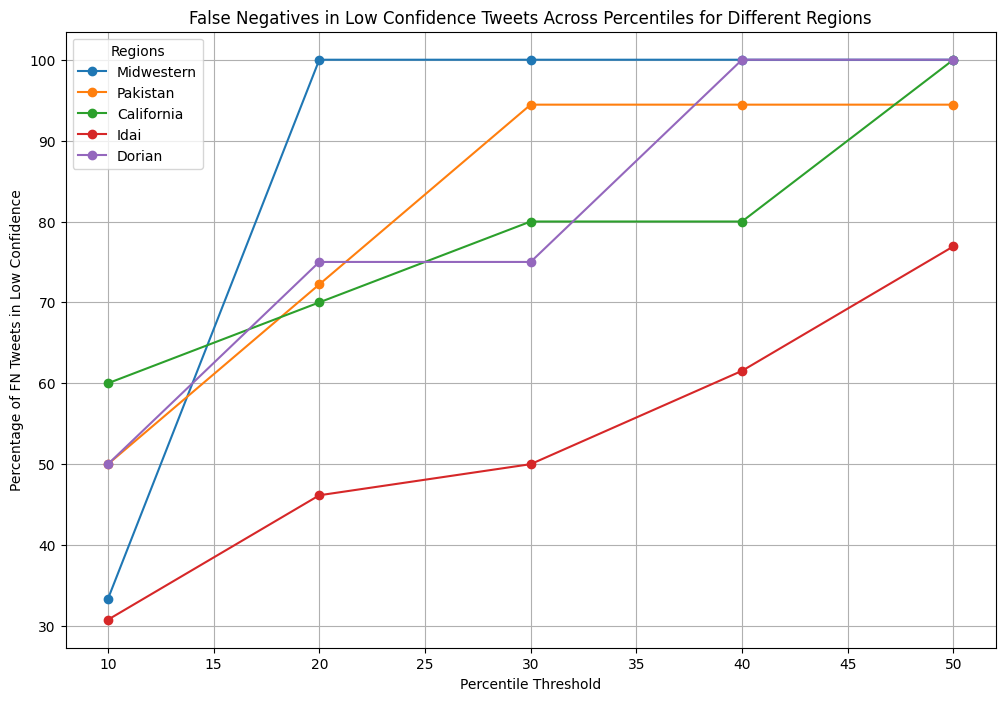

In [127]:
import matplotlib.pyplot as plt

def plot_multiple_regions(region_data, region_names, save_path=None):

    plt.figure(figsize=(12, 8))

    # Iterate over regions and plot their data
    for data, name in zip(region_data, region_names):
        percentiles = list(data.keys())
        percentages = list(data.values())
        plt.plot(percentiles, percentages, marker='o', label=name)
    
    # Add labels, title, legend, and grid
    plt.xlabel("Percentile Threshold")
    plt.ylabel("Percentage of FN Tweets in Low Confidence")
    plt.title("False Negatives in Low Confidence Tweets Across Percentiles for Different Regions")
    plt.grid(True)
    plt.legend(title="Regions")
    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout
        print(f"Plot saved to {save_path}")
    
    plt.show()
  

# Example usage
region_data = [mid, pak, cal, ida, dor]
region_names = ["Midwestern", "Pakistan", "California", "Idai", "Dorian"]

plot_multiple_regions(region_data, region_names, save_path="region_comparison.png")


In [28]:
mid=give_results_all(all_results_midwestern)
pak=give_results_all(all_results_pakistan)
cal=give_results_all(all_results_california)
ida=give_results_all(all_results_idai)
dor=give_results_all(all_results_dorian)

Plot saved to region_comparison100.png


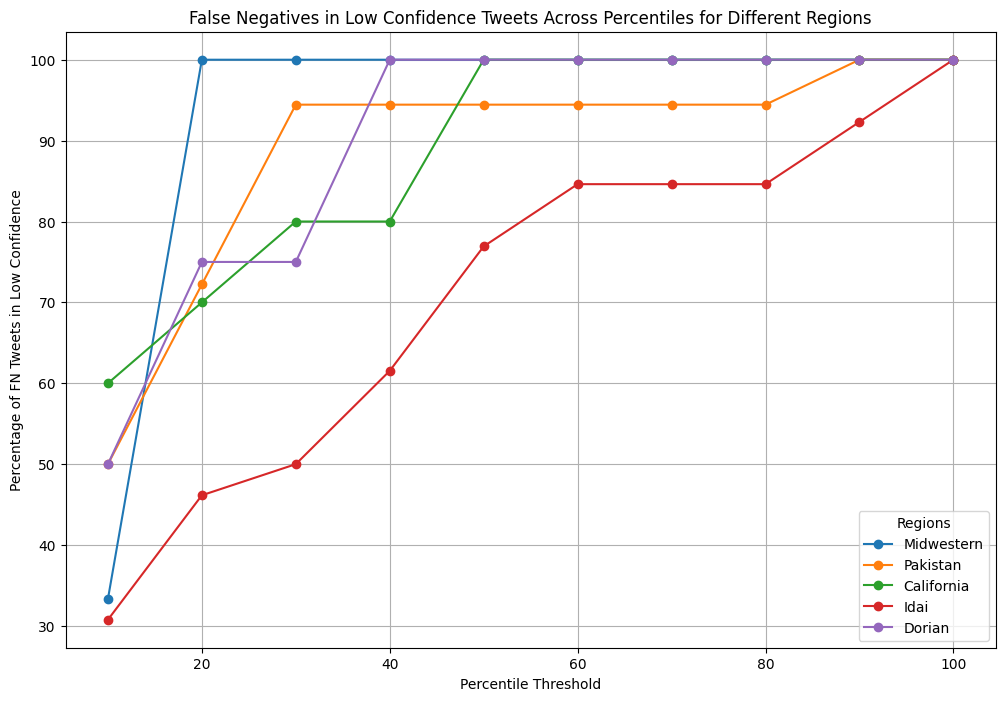

In [29]:
import matplotlib.pyplot as plt

def plot_multiple_regions(region_data, region_names, save_path=None):

    plt.figure(figsize=(12, 8))

    # Iterate over regions and plot their data
    for data, name in zip(region_data, region_names):
        percentiles = list(data.keys())
        percentages = list(data.values())
        plt.plot(percentiles, percentages, marker='o', label=name)
    
    # Add labels, title, legend, and grid
    plt.xlabel("Percentile Threshold")
    plt.ylabel("Percentage of FN Tweets in Low Confidence")
    plt.title("False Negatives in Low Confidence Tweets Across Percentiles for Different Regions")
    plt.grid(True)
    plt.legend(title="Regions")
    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout
        print(f"Plot saved to {save_path}")
    
    plt.show()
  

# Example usage
region_data = [mid, pak, cal, ida, dor]
region_names = ["Midwestern", "Pakistan", "California", "Idai", "Dorian"]

plot_multiple_regions(region_data, region_names, save_path="region_comparison100.png")

## GETTING NEIGHBOURING WORDS

In [186]:
# Function to get neighbouring words
def get_neighbouring_words(tweet, least_word, placeholder='x'):
    # Split the tweet into a list of words
    words = tweet.split()
    
    # Find the index of the least contributing word
    try:
        index = words.index(least_word)
    except ValueError:
        return f"{placeholder} {least_word} {placeholder}"  # Handle case where word not in tweet
    
    # Get the neighbours (handle boundary conditions)
    prev_word = words[index - 1] if index > 0 else placeholder
    next_word = words[index + 1] if index < len(words) - 1 else placeholder
    
    # Return the formatted sequence
    return f"{prev_word} {least_word} {next_word}"


def get_neighbouring_words_adjusted(tweet, least_word, placeholder='x'):
    # Split the tweet into a list of words
    words = tweet.split()
    
    # Check if the least contributing word is in the tweet
    try:
        index = words.index(least_word)
    except ValueError:
        # Return with placeholders if the word isn't in the tweet
        return f"{placeholder} {least_word} {placeholder}"

    def is_valid(word):
        # Check if a word is not punctuation or a stop word
        return word not in string.punctuation and word.lower() not in stop_words

    # Find the previous valid word
    prev_word = placeholder
    for i in range(index - 1, -1, -1):
        if is_valid(words[i]):
            prev_word = words[i]
            break

    # Find the next valid word
    next_word = placeholder
    for i in range(index + 1, len(words)):
        if is_valid(words[i]):
            next_word = words[i]
            break

    # Return the sequence with adjusted neighbors
    return f"{prev_word} {least_word} {next_word}"



In [187]:
# Function to process each location
def process_location(explanations, location_name):

    # Convert the explanations to a DataFrame
    df = pd.DataFrame(explanations)
    
    # Generate neighbouring words
    df['neighbouring_words'] = df.apply(
        lambda row: get_neighbouring_words(row['tweet'], row['least_contributing_word']),
        axis=1
    )
    
    # Generate adjusted neighbouring words
    df['neighbouring_words_adjusted'] = df.apply(
        lambda row: get_neighbouring_words_adjusted(row['tweet'], row['least_contributing_word']),
        axis=1
    )
    
    # Save to Excel
    file_name = f'neighbours_{location_name}.xlsx'
    df.to_excel(file_name, index=False)

# Process each location
# process_location(explanations_midwestern, 'midwestern')
# process_location(explanations_pakistan, 'pakistan')
# process_location(explanations_california, 'california')
# process_location(explanations_idai, 'idai')
# process_location(explanations_dorian, 'dorian')


# GETTING THE FALSE NEGATIVES 

In [14]:
# Loading results
california=load_all_results(filename="california.pkl")
idai = load_all_results(filename="idai.pkl")
pakistan = load_all_results(filename="pakistan.pkl")
dorian = load_all_results(filename="dorian.pkl")
midwestern = load_all_results(filename="midwestern.pkl")


All results loaded from california.pkl
All results loaded from idai.pkl
All results loaded from pakistan.pkl
All results loaded from dorian.pkl
All results loaded from midwestern.pkl


In [15]:
dorian

['Dorian is still a category 5 hurricane . The storms speed has slowed again . Chatham remains in the cone and wecould see potential impacts of strong winds , heavy rains , and coastal flooding in our area mid to late this week . Take time now to finalize your preparedness efforts .',
 '# HurricaneDorian is devastating islands south of us and slowing down and can potentially cause even more damage . If you believe the power in prayer , here ’s one for you . # PrayingfortheBahamas',
 'Hurricane # Dorian Dangerous Category 5 , sustained winds of 175 mph . If you live along the East Coast be prepared , gather supplies and evacuate if ordered . @philanthropy_pa @pulte @MrBeastYT @paul_L_obrien @SBRCelebrityArt @codeofvets @CLWAL02 @joepalojoe @KHOV2019 @HandInHandGP']

In [23]:
midwestern


['Flood relief center established by UNMC / Nebraska Medicine , UNO',
 '# mudfloods2019 told you so ” more to come @realdonaldtrump summer will be Worst flooding in history , look @Nebraska , damage surpasses 1.3 billion',
 'Due to horrible floods , damage to crops and lost livestock has cost Midwestern farmers lots of money . With so much loss , staying in business will be a struggle for the future . # ANS211',
 '@Nebraska Help us get former all time great Husker running back Roger Craig into the Hall of Fame ! Please retweet this petition to get the word out !',
 'Flooding overtook the Midwest and destroyed farmlands and drowned or stranded livestock . What lies ahead for these farmers ?',
 'REALTORS ® Disaster Relief Effort---- MORTGAGE AND RENTAL ASSISTANCE GRANT The Nebraska REALTORS ® Association and the Home Buyers Assistance Foundation have partnered with the REALTORS ® Relief Foundation to']

In [3]:
def neighbouring_words(tweet, least_word, placeholder='x'):
    # Split the tweet into a list of words
    words = tweet.split()
    print(words)
    
    # Find the index of the least contributing word
    try:
        index = words.index(least_word)
        print(index)
    except ValueError:
        return f"{placeholder} {least_word} {placeholder}"  # Handle case where word not in tweet
    
    # Get the neighbours (handle boundary conditions)
    prev_word = words[index - 1] if index > 0 else placeholder
    next_word = words[index + 1] if index < len(words) - 1 else placeholder
    
    # Return the formatted sequence
    return f"{prev_word} {least_word} {next_word}"

In [4]:
neighbouring_words('@Nebraska Help us get former all time great Husker running back Roger Craig into the Hall of Fame ! Please retweet this petition to get the word out !',
                   'Nebraska')

['@Nebraska', 'Help', 'us', 'get', 'former', 'all', 'time', 'great', 'Husker', 'running', 'back', 'Roger', 'Craig', 'into', 'the', 'Hall', 'of', 'Fame', '!', 'Please', 'retweet', 'this', 'petition', 'to', 'get', 'the', 'word', 'out', '!']


'x Nebraska x'

### Looking for conflicts in MANUAL VS AUTOMATIC LABELLING



In [23]:
test_california[test_california['sentence']=='This is an absolutely heartless response . There are n’t even politics involved . Just good American families losing their homes as you tweet , evacuating into shelters .']

,sentence,word_labels
0,This is an absolutely heartless response . The...,"LOC,O,O,O,O,O,O,O,O,O,O,O,O"
1,This is an absolutely heartless response . The...,"O,O,O,O,O,O"
2,This is an absolutely heartless response . The...,"O,O,O,O,O,O,LOC,LOC,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
3,This is an absolutely heartless response . The...,"O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O,O,O,O,O,O,..."
4,This is an absolutely heartless response . The...,"O,O,O,LOC,O,O,O,O,O,O,O,O,O,O"
...,...,...
1165,This is an absolutely heartless response . The...,"O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O"
1166,This is an absolutely heartless response . The...,"O,O,O,O,O,LOC,O,O,O,O,O,O,O,LOC,O,O,O,O,O,O,LO..."
1167,This is an absolutely heartless response . The...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
1168,This is an absolutely heartless response . The...,"O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,LOC,LOC,O,..."


In [24]:
test_california

,sentence,word_labels
0,This is an absolutely heartless response . The...,"LOC,O,O,O,O,O,O,O,O,O,O,O,O"
1,This is an absolutely heartless response . The...,"O,O,O,O,O,O"
2,This is an absolutely heartless response . The...,"O,O,O,O,O,O,LOC,LOC,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
3,This is an absolutely heartless response . The...,"O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O,O,O,O,O,O,..."
4,This is an absolutely heartless response . The...,"O,O,O,LOC,O,O,O,O,O,O,O,O,O,O"
...,...,...
1165,This is an absolutely heartless response . The...,"O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O"
1166,This is an absolutely heartless response . The...,"O,O,O,O,O,LOC,O,O,O,O,O,O,O,LOC,O,O,O,O,O,O,LO..."
1167,This is an absolutely heartless response . The...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
1168,This is an absolutely heartless response . The...,"O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,LOC,LOC,O,..."


In [144]:
def print_sentence_with_labels(row, sentence_col='sentence', labels_col='word_labels'):
    # Extract sentence and labels
    sentence_words = str(row[sentence_col]).split()   # Split sentence into words
    word_labels = str(row[labels_col]).split(',')     # Split labels by comma
    
    print("Processing Sentence:")
    # Pair words with their corresponding labels
    for word, label in zip(sentence_words, word_labels):
        print(f"  {word} -> {label}")
    
    # Check for mismatched lengths
    if len(sentence_words) != len(word_labels):
        print(f"Warning: Length mismatch! Words: {len(sentence_words)}, Labels: {len(word_labels)}")


row = test_idai.iloc[276]  
print_sentence_with_labels(row)



Processing Sentence:
  We -> O
  are -> O
  saddened -> O
  by -> O
  the -> O
  terrible -> O
  news -> O
  of -> O
  deaths -> O
  & -> O
  devastation -> O
  in -> O
  the -> O
  Eastern -> LOC
  Highlands -> LOC
  , -> O
  caused -> O
  by -> O
  # -> O
  CycloneIdai -> O
  . -> O
  Our -> O
  thoughts -> O
  go -> O
  out -> O
  to -> O
  those -> O
  who -> O
  lost -> O
  loved -> O
  ones -> O
  & -> O
  property -> O
  - -> O
  and -> O
  to -> O
  those -> O
  who -> O
  are -> O
  tirelessly -> O
  trying -> O
  to -> O
  save -> O
  lives -> O
  & -> O
  belongings -> O
  . -> O
  The -> O
  EU -> O
  stands -> O
  ready -> O
  to -> O
  assist -> O
  ! -> O
  # -> O
  EUinZim -> O



# Random Experiment with 30% of the Negative Tweets

In [188]:
def random_selection_experiment(negative_tweets, percentage=30, num_trials=10, seed=None):
  
    if seed is not None:
        random.seed(seed)  #  base seed

    results_per_trial = []

    # Get the total number of false negatives in negative tweets
    total_fn_count, false_negative_tweets = count_false_negatives_in_negative_tweets(negative_tweets)
    total_fn_tweets = len(false_negative_tweets)  # Total number of tweets containing FN

    print(f"Total Negative Tweets: {len(negative_tweets)}")
    print(f"Total Tweets with False Negatives in Negative Set: {total_fn_tweets}")

    for i in range(num_trials):
        trial_seed = seed + i if seed is not None else None  # Vary seed per trial

      
        num_to_select = max(1, int(len(negative_tweets) * (percentage / 100)))  # Ensure at least 1 tweet
        selected_tweets = random.sample(negative_tweets, num_to_select)

        # existing function to count false negatives in selected tweets
        fn_count_random, fn_tweets_random = count_false_negatives_in_negative_tweets(selected_tweets)

        # Percentage of total FN tweets that appear in the randomly selected set
        percentage_fn_captured = (len(fn_tweets_random) / total_fn_tweets) * 100 if total_fn_tweets > 0 else 0

        results_per_trial.append(percentage_fn_captured)

        # print(f"Trial {i+1}:")
        # print(f"  - Randomly Selected Tweets: {num_to_select}")
        # print(f"  - Tweets with False Negatives in Selection: {len(fn_tweets_random)}")
        # print(f"  - Percentage of Total FN Tweets Captured: {percentage_fn_captured:.2f}%\n")

    # Compute the average FN percentage captured across all trials
    avg_percentage_fn_captured = np.mean(results_per_trial)

    print("=" * 50)
    print(f"Average Percentage of Total FN Tweets Captured in Random Selection: {avg_percentage_fn_captured:.2f}%")
    print("=" * 50)

    return avg_percentage_fn_captured, results_per_trial





In [48]:

print('Idai')
negative_tweets_count, negative_tweet_indices, negative_tweets = count_negative_tweets(all_results_idai)

# Run the experiment
avg_fn_percentage_random, trials_results = random_selection_experiment(
    negative_tweets, percentage=30, num_trials=10, seed=42
)


print('California')
negative_tweets_count, negative_tweet_indices, negative_tweets = count_negative_tweets(all_results_california)
avg_fn_percentage_random, trials_results = random_selection_experiment(
    negative_tweets, percentage=30, num_trials=10, seed=42
)

print('pakistan')
negative_tweets_count, negative_tweet_indices, negative_tweets = count_negative_tweets(all_results_pakistan)

# Run the experiment
avg_fn_percentage_random, trials_results = random_selection_experiment(
    negative_tweets, percentage=30, num_trials=10, seed=42
)



print('dorian')
negative_tweets_count, negative_tweet_indices, negative_tweets = count_negative_tweets(all_results_dorian)

# Run the experiment
avg_fn_percentage_random, trials_results = random_selection_experiment(
    negative_tweets, percentage=30, num_trials=10, seed=42
)

print('midwestern')
negative_tweets_count, negative_tweet_indices, negative_tweets = count_negative_tweets(all_results_midwestern)

# Run the experiment
avg_fn_percentage_random, trials_results = random_selection_experiment(
    negative_tweets, percentage=30, num_trials=10, seed=42
)


print('all')
negative_tweets_count, negative_tweet_indices, negative_tweets = count_negative_tweets(all_results)

# Run the experiment
avg_fn_percentage_random, trials_results = random_selection_experiment(
    negative_tweets, percentage=30, num_trials=10, seed=42
)



Idai
Total Negative Tweets: 290
Total Tweets with False Negatives in Negative Set: 26
Average Percentage of Total FN Tweets Captured in Random Selection: 31.54%
California
Total Negative Tweets: 206
Total Tweets with False Negatives in Negative Set: 10
Average Percentage of Total FN Tweets Captured in Random Selection: 26.00%
pakistan
Total Negative Tweets: 116
Total Tweets with False Negatives in Negative Set: 18
Average Percentage of Total FN Tweets Captured in Random Selection: 27.22%
dorian
Total Negative Tweets: 37
Total Tweets with False Negatives in Negative Set: 4
Average Percentage of Total FN Tweets Captured in Random Selection: 45.00%
midwestern
Total Negative Tweets: 62
Total Tweets with False Negatives in Negative Set: 6
Average Percentage of Total FN Tweets Captured in Random Selection: 28.33%
all
Total Negative Tweets: 711
Total Tweets with False Negatives in Negative Set: 64
Average Percentage of Total FN Tweets Captured in Random Selection: 29.38%


In [50]:
#Example of Averaging for California
print('California')
negative_tweets_count, negative_tweet_indices, negative_tweets = count_negative_tweets(all_results_california)
avg_fn_percentage_random, trials_results = random_selection_experiment(
    negative_tweets, percentage=30, num_trials=10, seed=42
)


California
Total Negative Tweets: 206
Total Tweets with False Negatives in Negative Set: 10
Trial 1:
  - Randomly Selected Tweets: 61
  - Tweets with False Negatives in Selection: 5
  - Percentage of Total FN Tweets Captured: 50.00%

Trial 2:
  - Randomly Selected Tweets: 61
  - Tweets with False Negatives in Selection: 0
  - Percentage of Total FN Tweets Captured: 0.00%

Trial 3:
  - Randomly Selected Tweets: 61
  - Tweets with False Negatives in Selection: 3
  - Percentage of Total FN Tweets Captured: 30.00%

Trial 4:
  - Randomly Selected Tweets: 61
  - Tweets with False Negatives in Selection: 3
  - Percentage of Total FN Tweets Captured: 30.00%

Trial 5:
  - Randomly Selected Tweets: 61
  - Tweets with False Negatives in Selection: 3
  - Percentage of Total FN Tweets Captured: 30.00%

Trial 6:
  - Randomly Selected Tweets: 61
  - Tweets with False Negatives in Selection: 5
  - Percentage of Total FN Tweets Captured: 50.00%

Trial 7:
  - Randomly Selected Tweets: 61
  - Tweets with

# TESTING ON NEW LOCATIONS



### Script to convert events-2.xlsx to .txt with tags. The same script can also be found under Data > TestData > NewLocation > NewLocation.ipynb

In [189]:
# import pandas as pd
# import json
# import re
# from nltk.corpus import stopwords
# import nltk

# # Ensure stopwords are downloaded
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# def extract_locations(location_data):
#     """Extract location names from the JSON in the locations column."""
#     locations = set()
#     try:
#         data_list = json.loads(f"[{location_data}]")  # Ensure JSON is parsed as a list
#         for entry in data_list:
#             if isinstance(entry, dict) and "properties.name" in entry:
#                 locations.update(entry["properties.name"])
#     except Exception:
#         pass
#     return locations

# def tag_text(text, locations):
#     """Tag tokens in the text based on extracted locations, handling partial matches while ignoring stopwords."""
#     words = text.split()
#     tagged_words = []
    
#     # Normalize location names to match variations in text
#     normalized_locs = {loc.lower(): loc for loc in locations}
#     location_tokens = set()
#     for loc in normalized_locs:
#         tokens = [token for token in loc.split() if token.lower() not in stop_words]  # Remove stopwords
#         location_tokens.update(tokens)
    
#     for word in words:
#         word_clean = re.sub(r'[^\w]', '', word).lower()
        
#         # Check exact match or if any meaningful part of a location name matches
#         if word_clean in location_tokens or any(word_clean in loc.lower().split() and word_clean not in stop_words for loc in locations):
#             tagged_words.append(f"{word} LOC")
#         else:
#             tagged_words.append(f"{word} O")
    
#     return "\n".join(tagged_words)

# def process_excel(file_path, output_txt):
#     df = pd.read_excel(file_path)
#     df["locations"] = df["locations"].astype(str)  # Ensure it's string for JSON parsing
    
#     with open(output_txt, "w", encoding="utf-8") as f:
#         for _, row in df.iterrows():
#             locations = extract_locations(row["locations"])
#             tagged_text = tag_text(row["text"], locations)
#             f.write(tagged_text + "\n\n")

# # Example usage:
# process_excel("events-2.xlsx", "output1.txt")
test_new= ingest_idrisi_data('Test/new/newnew')

In [190]:
test_new

,sentence,word_labels
0,The number of dead and missing after tropical ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O,O"
1,The death toll in tropical storm Trami that sl...,"O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O,O,O,O,O,O,O,..."
2,The number of deaths and missing in massive fl...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,..."
3,- Manila: Cyclone '#Trami' makes waves in the ...,"O,LOC,O,O,O,O,O,O,LOC,O,O,O,O,O,O,O,LOC,O,O,O,..."
4,the current situation in the camsur segment of...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
...,...,...
1272,heart breaking lahat ng post sa feed ng fb ko ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O"
1273,"Submerged vehicles in Iriga City, Camarines Su...","O,O,O,LOC,LOC,O,LOC,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
1274,"If you come across this tweet, please say a sh...","O,O,O,O,O,O,O,O,O,O,O,O,O,LOC,O,O,O,O,O,O,O,O,..."
1275,Naga City is flooded. Waters continue to rise....,"LOC,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."


In [92]:
# testset_new=  dataset(test_new, tokenizer, MAX_LEN)
# testing_new= DataLoader(testset_new, **test_params)

In [93]:
# all_results_new= valid(model, testing_new, tokenizer,id2label, test_new['sentence'])

Validation Loss: 0.07235333259191311
Validation Accuracy: 0.9610961576065858


In [8]:
# save_all_results(all_results_new, filename="all_results_new.pkl")
all_results_new=load_all_results(filename="all_results_new.pkl")


All results loaded from all_results_new.pkl


In [10]:
#This is F1 Score for each label level
calculate_f1_and_report(all_results_new)

Classification Report:
              precision    recall  f1-score   support

         LOC       0.56      0.74      0.64      3837
           O       0.99      0.97      0.98     69265

    accuracy                           0.96     73102
   macro avg       0.77      0.85      0.81     73102
weighted avg       0.96      0.96      0.96     73102



np.float64(0.8080074778785069)

In [33]:
# new_results=give_results(all_results_new)
negative_tweets_count, negative_tweet_indices, negative_tweets= give_results(all_results_new)

print(negative_tweet_indices)

Total no. of Tweets:1277 
Macro F1 Score:  0.81
Total no. of Negative Tweets: 17
No of tweets with false negatives in Negative Tweets: 5
30th Percentile of Min probs: 0.7423974275588989
Total filtered tweets (below 30th percentile): 5
No. of FN tweets below 30th percentile: 4
Percentage of FN tweets in low confidence: 80.00 %
[5, 23, 36, 58, 92, 409, 516, 541, 599, 628, 649, 721, 774, 859, 1051, 1177, 1184]


In [ ]:
from sklearn.metrics import f1_score, classification_report
#THIS IS THE F1 SCORE CALCUATE PER TWEET AND THEN AGG
def calculate_per_tweet_f1(results):
    tweet_f1_scores = []  # F1 score for each tweet
    all_true_labels = []  # Aggregated true labels for all tweets
    all_pred_labels = []  # Aggregated predicted labels for all tweets

    for tweet_result in results:
        true_labels = []  # True labels for the current tweet
        pred_labels = []  # Predicted labels for the current tweet

        for item in tweet_result:
            token = item['token']
            true_label = item['label']
            pred_label = item['prediction']

            # Exclude special tokens: [CLS], [SEP], and [PAD]
            if token not in ['[CLS]', '[SEP]', '[PAD]']:
                true_labels.append(true_label)
                pred_labels.append(pred_label)
        
        # Calculate F1 score for the current tweet
        if len(set(true_labels)) > 1:  # Ensure there are at least two classes
            tweet_f1 = f1_score(true_labels, pred_labels, average='macro')  # or 'weighted'
        else:
            tweet_f1 = 1.0  # If all labels are the same, F1 is 1.0 (perfect prediction)
        
        tweet_f1_scores.append(tweet_f1)

        # Aggregate labels for classification report
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)
    
    # Average F1 scores across all tweets
    average_f1 = sum(tweet_f1_scores) / len(tweet_f1_scores)

    # Generate classification report
    report = classification_report(all_true_labels, all_pred_labels)

    return average_f1, report

In [42]:
average_f1, tweet_f1_scores= calculate_per_tweet_f1(all_results_new)
average_f1

np.float64(0.8622269480584154)

In [192]:
new_n_lc= get_n_lc_tweets(new_results)
# save_all_results(new_n_lc, filename="new_neg.pkl")
new_n=load_all_results(filename="new_neg.pkl")




All results loaded from new_neg.pkl


In [193]:
#EXPLANATIONS
# explanations_new= least_contributing_word(new_n)
# save_all_results(explanations_new, filename="explanations_new.pkl")
explanations_new= load_all_results(filename="explanations_new.pkl")
pd.DataFrame(explanations_new)


All results loaded from explanations_new.pkl


,tweet,least_contributing_word
0,Noveleta Mayor Dino Chua urged the national go...,Chua
1,Noveleta Mayor Dino Chua urged other agencies ...,Mayor
2,"DOGS ARE MY WEAK SPOT BESIDES MY FAMILY, like ...",in
3,Sorsogon MDRRMO head Edgar Aradales Jr. says t...,Sorsogon
4,According to sender Maria Joy Abendaño Liwanag...,Liwanag


In [142]:
#getting the neighboring words
process_location(explanations_new, 'new')

In [143]:
pd.read_excel('neighbours_new.xlsx')

,tweet,least_contributing_word,neighbouring_words,neighbouring_words_adjusted
0,Noveleta Mayor Dino Chua urged the national go...,Chua,Dino Chua urged,Dino Chua urged
1,Noveleta Mayor Dino Chua urged other agencies ...,Mayor,Noveleta Mayor Dino,Noveleta Mayor Dino
2,"DOGS ARE MY WEAK SPOT BESIDES MY FAMILY, like ...",in,crying in the,crying in morning
3,Sorsogon MDRRMO head Edgar Aradales Jr. says t...,Sorsogon,x Sorsogon MDRRMO,x Sorsogon MDRRMO
4,According to sender Maria Joy Abendaño Liwanag...,Liwanag,Benjie Liwanag |via,Benjie Liwanag |via


In [149]:
newnew = load_all_results(filename="newnew.pkl")

All results loaded from newnew.pkl


In [151]:
#these are the false newgatives in the new tweets
newnew

['Noveleta Mayor Dino Chua urged the national government to send heavy equipment to the municipality, where many areas remained covered with thick mud, garbage, and debris due to the heavy flooding from severe tropical storm #KristinePH. READ: https://t.co/USb4XulPq0 https://t.co/RUatsr6oaI',
 'Noveleta Mayor Dino Chua urged other agencies and the national government to send heavy equipment to the municipality, as many areas remained inundated due to the heavy rains from Severe Tropical Storm Kristine. https://t.co/o6ruQaufSZ',
 'Sorsogon MDRRMO head Edgar Aradales Jr. says the flooding brought by the downpour due to #KristinePH in the area has begun to subside today, Oct. 23. https://t.co/hnSbEbgNM5',
 'According to sender Maria Joy Abendaño Liwanag, the photos were sent to her by her brother who is still currently at the said mall which had been flooded since 5:00PM afternoon. Photo courtesy of Benjie Liwanag |via Reign Flores, The APEX #KristinePH #FloodPH #nagacity #Bicol']